In [1]:
#from transformers import Wav2Vec2Processor,AutoFeatureExtractor,Wav2Vec2Model,AutoFeatureExtractor
import torch
import PreProc
import librosa
import numpy as np
import scipy
from fast_transformers.builders import TransformerEncoderBuilder
from positional_encodings.torch_encodings import PositionalEncoding1D,Summer
import pytorch_lightning as pl
from pytorch_metric_learning import losses
from torch.utils.data import DataLoader,TensorDataset
torch.set_float32_matmul_precision('medium')
import torchaudio
from torchmetrics.wrappers import Running
from torchmetrics.aggregation import MeanMetric
from sklearn.preprocessing import robust_scale
from torch import nn

In [2]:
X,attended,masker,_ = PreProc.load_data(14)

In [3]:
class CLoss(torch.nn.Module):
    def __init__(self,mean,lin,scale):
        super().__init__()
        self.mean = mean
        self.lin = lin
        self.scale = scale
    
    def forward(self,eemb,aamb):
        if self.mean:
            aamb = torch.mean(aamb,dim=1,keepdim=True)
            eemb = torch.mean(eemb,dim=1,keepdim=True)


        if self.scale:
            eemb =(eemb - eemb.mean(dim=(1,2),keepdim=True))
            aamb =(aamb - aamb.mean(dim=(1,2),keepdim=True))


        norm = 1/(1e-8 + eemb.norm(dim=(1,2)))

        labels = torch.arange(len(eemb),device=aamb.device)

        logits = torch.einsum('btc,rtc,b->br',eemb,aamb,norm)

        return torch.nn.functional.cross_entropy(logits,labels)

In [4]:
def prep_EEG(eeg):
    #[b,a] = scipy.signal.butter(3,[10*2,32*2],btype = "bandpass",fs=256)
    #eg = scipy.signal.lfilter(b,a,X,axis=-1)
    #eeg = scipy.signal.resample(eeg,4224,axis=-1)
    EEG = []
    for ee in eeg:
        #ee = ee/np.linalg.norm(ee,2)
        #ee = scipy.signal.resample(ee,2112)
        ee = robust_scale(ee,axis=1)
        e = np.split(ee,11,axis=-1)
        EEG.append(e)
    EEG = np.array(EEG)
    EEG = EEG.reshape((EEG.shape[0]*EEG.shape[1],1, EEG.shape[2],EEG.shape[3]))
    return EEG

In [5]:
EEG = prep_EEG(X)

In [6]:
EEG.shape

(11440, 1, 64, 768)

In [7]:
def load_and_prep(filenames,n_splits=11):
    out = []
    for fname in filenames:
        y,_ = librosa.load(fname,sr=16000)
        y_split = np.array(np.split(y,n_splits))
        out.append(y_split)
    out = np.array(out)
    return out.reshape((out.shape[0]*out.shape[1],out.shape[2]))


In [8]:
def load_and_mel(filenames,n_splits=11):
    out = []
    for fname in filenames:
        spect = []
        y,_ = librosa.load(fname,sr=16000)
        y_split = np.array(np.split(y,n_splits))
        for split in y_split:
            mel = np.log(1e-5 + librosa.feature.melspectrogram(y=split,n_fft=2048,hop_length=512,norm = 'slaney',n_mels=80))
            spect.append(mel)
        out.append(spect)
    out = np.array(out)
    return out.reshape((out.shape[0]*out.shape[1],out.shape[2],out.shape[3]))


In [9]:
att = load_and_mel(attended)
mas = load_and_mel(masker)

In [37]:
class CNN(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1,8,5,padding="same")
        self.drop = nn.Dropout(0.4)
        self.drop2 = nn.Dropout(0.4)
        self.conv2 = nn.Conv2d(8,16,7,padding="same")
        self.conv3 = nn.Conv2d(16,64,1,padding="same")

        self.avg = nn.AvgPool2d((64,1))

    def forward(self,x):

        out = self.conv1(x)
        out = self.drop(out)
        out = self.conv2(out)
        out = self.drop2(out)
        out = self.conv3(out)

        out = self.avg(out)

        out = out.squeeze(2)

        return out



In [21]:
class ProjectionHead(torch.nn.Module):
    def __init__(self,proj_dim,dropout):
        super().__init__()
        self.proj_dim = proj_dim
        self.dropout = dropout
        self.gelu = torch.nn.GELU()
        self.dropout = torch.nn.Dropout(self.dropout)
        self.proj = torch.nn.LazyLinear(proj_dim)
        self.fc = torch.nn.Linear(proj_dim,proj_dim)
        self.lnorm = torch.nn.LayerNorm(proj_dim)
    
    def forward(self,x):
        proj = self.proj(x)
        out = self.gelu(proj)
        out = self.fc(out)
        out = self.dropout(out)
        out = out + proj
        out = self.lnorm(out)
        return out


In [22]:
class EEG_Encoder(torch.nn.Module):
    def __init__(self,dff=512,n_layers=4,n_heads=4,times = 768):
        super().__init__()

        self.cn = CNN()
        self.times = times
        self.proj = ProjectionHead(80,0.4)
        self.posenc = Summer(PositionalEncoding1D(128))
        self.emb = torch.nn.Linear(64,128)
        self.encl = nn.TransformerEncoderLayer(d_model=128,nhead=n_heads,dropout=0.4,activation="relu",batch_first=True,norm_first=True,dim_feedforward=512)
        self.enc = nn.TransformerEncoder(self.encl,num_layers=n_layers,norm = nn.LayerNorm([self.times,128]))
        self.linl = nn.Linear(self.times,94)


        
        
    def forward(self,x):

        out = self.cn(x)
        out = torch.permute(out,(0,2,1))
        out = self.emb(out)

        out = self.posenc(out)

        out = self.enc(out)

        out = torch.permute(out,(0,2,1))

        out = self.linl(out)

        out = torch.permute(out,(0,2,1))

        out = self.proj(out)


        return out

In [13]:
class Audio_Model(torch.nn.Module):
    def __init__(self,aud):
        super().__init__()
        self.model = aud()
        for p in self.model.parameters():
            p.required_grad = False
        #self.linl = torch.nn.Linear(768,256)
        self.proj = ProjectionHead(128,0.4)

    def forward(self,x):
        out = torch.stack(self.model.extract_features(x,num_layers=10)[0][8:]).mean(dim=0)
        #out = self.linl(out)
        out = self.proj(out)
        return out

In [28]:
att = np.transpose(att,[0,2,1])
mas = np.transpose(mas,[0,2,1])

In [33]:
class LitAutoEncoder(pl.LightningModule):
    def __init__(self):
        super().__init__()
        self.encoder = EEG_Encoder()
        #self.aud_model = Audio_Model(bundle.get_model)
        #self.linl = torch.nn.Linear(768,256).to('cuda')
        self.loss_fn = CLoss(mean=False,lin=True,scale=True)
        self.running_loss = Running(MeanMetric(), window=10)
        #self.audmod = Wav2Vec2Model.from_pretrained("Clementapa/wav2vec2-base-960h-phoneme-reco-dutch"
        #self.los = criterion()

    def forward(self, x):
        # in lightning, forward defines the prediction/inference actions
        embedding = self.encoder(x)
        return embedding

    def training_step(self, batch, batch_idx):
        # training_step defines the train loop. It is independent of forward
        eeg,att,mas = batch

        
        
        eeg_emb = self.encoder(eeg)

        '''
        with torch.no_grad():
            att_emb = self.aud_model(att)
            mas_emb = self.aud_model(mas)

        '''

        tembs = torch.cat([att,mas])
        



        loss = (self.loss_fn(eeg_emb,tembs) + self.loss_fn(att,eeg_emb))/2

        self.running_loss(loss)
        tqdm_dict = {'train_loss': loss}
        self.log('train_loss', self.running_loss.compute(), on_step=True, prog_bar=True)
        outputs = {
            'loss': loss,
            'progress_bar': tqdm_dict,
            'log': tqdm_dict
        }
        return outputs
    
    def validation_step(self, batch, batch_idx):
        # training_step defines the train loop. It is independent of forward
        eeg,att,mas = batch
        


        
        
        eeg_emb = self.encoder(eeg)
        '''
        with torch.no_grad():
            att_emb = self.aud_model(att)
            mas_emb = self.aud_model(mas)

            '''
       

        tembs = torch.cat([att,mas])



        loss = (self.loss_fn(eeg_emb,tembs) + self.loss_fn(att,eeg_emb))/2
        tqdm_dict = {'val_loss': loss}
        self.running_loss(loss)
        self.log('val_loss', self.running_loss.compute(), on_step=True, prog_bar=True)

        outputs = {
            'loss': loss,
            'progress_bar': tqdm_dict,
            'log': tqdm_dict
        }
        return outputs

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=2e-4)
        return optimizer

In [30]:
from sklearn.model_selection import train_test_split

X_tr,x_val,att_tr,att_val,mas_tr,mas_val = train_test_split(EEG,att,mas,test_size=0.1)


In [31]:
EEG_tr = torch.Tensor(X_tr)
att_tr = torch.Tensor(att_tr)
mas_tr = torch.Tensor(mas_tr)

trdata = TensorDataset(EEG_tr,att_tr,mas_tr)

train_loader = DataLoader(trdata, batch_size=16, num_workers=4, shuffle=True,persistent_workers=True)


EEG_val = torch.Tensor(x_val)
att_val = torch.Tensor(att_val)
mas_val = torch.Tensor(mas_val)

valdata = TensorDataset(EEG_val,att_val,mas_val)

val_loader = DataLoader(valdata, batch_size=16, num_workers=4,persistent_workers=True)

In [34]:
enc = LitAutoEncoder()

trainer = pl.Trainer(max_epochs=40,accelerator='gpu')
trainer.fit(enc, train_loader,val_dataloaders=val_loader)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
c:\Users\gauta\anaconda3\envs\keras-jax\lib\site-packages\pytorch_lightning\utilities\model_summary\model_summary.py:454: A layer with UninitializedParameter was found. Thus, the total number of parameters detected may be inaccurate.

  | Name         | Type        | Params
---------------------------------------------
0 | encoder      | EEG_Encoder | 1.3 M 
1 | loss_fn      | CLoss       | 0     
2 | running_loss | Running     | 0     
---------------------------------------------
1.3 M     Trainable params
0         Non-trainable params
1.3 M     Total params
5.131     Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

c:\Users\gauta\anaconda3\envs\keras-jax\lib\site-packages\pytorch_lightning\trainer\call.py:54: Detected KeyboardInterrupt, attempting graceful shutdown...


In [38]:
out = enc(EEG_tr[8].unsqueeze(0).to('cuda'))

RuntimeError: permute(sparse_coo): number of dimensions in the tensor input does not match the length of the desired ordering of dimensions i.e. input.dim() = 2 is not equal to len(dims) = 3

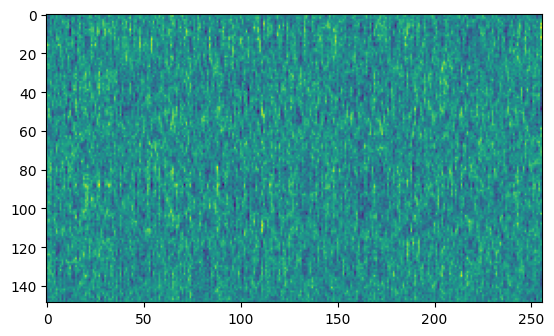

In [86]:
import matplotlib.pyplot as plt
plt.imshow(out.cpu().detach().numpy()[0])

In [87]:
bundle = torchaudio.pipelines.WAVLM_BASE
aud_model = Audio_Model(bundle.get_model).cpu()

In [96]:
k = aud_model(att_val[8].unsqueeze(0))

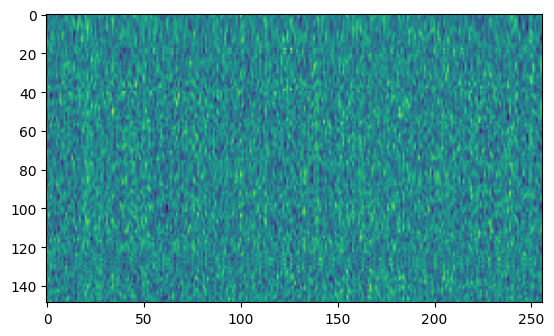

In [99]:
plt.imshow(pred[0].detach().numpy())

In [97]:
c = CLoss(mean=False,lin=True,scale=True)

pred,los = c(out,k)

tensor([[-0.0172]], grad_fn=<ViewBackward0>)


c:\Users\gauta\anaconda3\envs\keras-jax\lib\site-packages\torch\nn\modules\lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


In [98]:
pred

tensor([[[-0.2537,  0.3208, -0.0107,  ...,  0.1114,  0.0242,  0.2171],
         [-0.2208,  0.1763, -0.3342,  ...,  0.0805,  0.0608,  0.0356],
         [-0.2716,  0.0007, -0.1562,  ...,  0.1190, -0.0251,  0.1249],
         ...,
         [ 0.1353,  0.0109, -0.1298,  ...,  0.2167, -0.1034, -0.1546],
         [ 0.0035,  0.0420,  0.0183,  ...,  0.2578, -0.1109, -0.0479],
         [-0.0388,  0.1026,  0.3679,  ..., -0.0822, -0.1289,  0.0369]]],
       grad_fn=<SubBackward0>)

In [84]:
%reload_ext tensorboard
%tensorboard --logdir=lightning_logs/

Reusing TensorBoard on port 6006 (pid 11624), started 10:18:19 ago. (Use '!kill 11624' to kill it.)

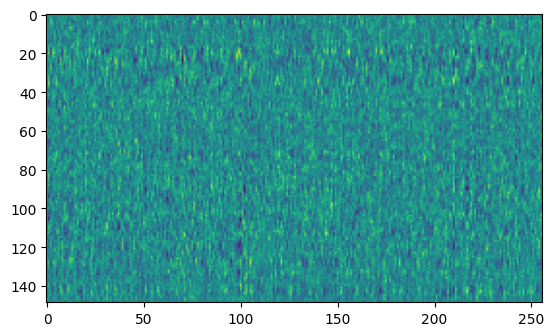

In [39]:
plt.imshow(pred[0].cpu().detach().numpy() - out[0].cpu().detach().numpy())

In [41]:
m = torch.einsum('btc,rtc->br',pred.cpu(),out.cpu())

In [42]:
m

tensor([[-5.6133]], grad_fn=<ViewBackward0>)

In [60]:
s

tensor([[[-0.1850, -0.1926, -0.1105,  ...,  0.7140,  0.1648, -0.1341],
         [-0.2515, -0.0999, -0.0406,  ...,  0.5010, -0.2349,  0.0530],
         [-0.1432, -0.1922,  0.2639,  ...,  0.3255, -0.2866,  0.0020],
         ...,
         [ 0.3835,  0.0248, -0.4298,  ..., -0.0412,  0.2126, -0.0788],
         [ 0.2112,  0.2183, -0.4016,  ..., -0.1105,  0.2310, -0.0443],
         [-0.0345,  0.3877, -0.1327,  ..., -0.3190, -0.0163, -0.1004]],

        [[-0.1592, -0.0133,  0.0886,  ...,  0.2502, -0.1285, -0.1744],
         [-0.0071,  0.4026,  0.4519,  ..., -0.3682, -0.1023, -0.1679],
         [ 0.0028,  0.3939,  0.4587,  ..., -0.4430,  0.0677, -0.1290],
         ...,
         [ 0.0882,  0.0576,  0.0354,  ...,  0.3051, -0.1614,  0.0110],
         [ 0.2155,  0.0233,  0.3100,  ...,  0.3124, -0.2464,  0.1564],
         [-0.0886, -0.0702, -0.0010,  ...,  0.5190,  0.0702, -0.0577]]],
       grad_fn=<MeanBackward1>)